In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
from tensorflow import keras
%matplotlib inline
import tensorflow_datasets as tfds
from time import time
   



In [2]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for _ in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        side = int(np.sqrt(batch.shape[1]))
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    print(np.sqrt(batch.shape[2]/n_channels))
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 160
        side_square = 10
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


In [3]:
#Define model params
batch_size = 2
batch_size_display = batch_size
n_iter_sinkhorn = 4000

temp = 5.0

#mnist data
n_squares_side = 30
n_channels = 3

n_squares = n_squares_side **2
n_gromov = 2
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)

In [4]:
#Now we define the main TF variables

def solve(scrambled_split,stack_scrambled_images_split,stack_real_images_split):
    
    print(scrambled_split.shape)
    log_alpha = np.reshape(stack_scrambled_images_split, [batch_size, n_squares, n_dim])
    log_alpha2 = np.reshape(stack_real_images_split, [batch_size, n_squares, n_dim])



    sq = np.sum(log_alpha **2, axis=2, keepdims=True)
    A = np.tile(sq, [1, 1, n_squares])
    B = np.tile(np.transpose(sq, [0,2 ,1]), [1, n_squares, 1])
    C = -2*np.matmul(log_alpha, np.transpose(log_alpha, [0, 2, 1]))
    s1 = A+B +C
    sq2 = np.sum(log_alpha2 **2, axis=2, keepdims=True)
    A2 = np.tile(sq2, [1, 1, n_squares])
    B2 = np.tile(np.transpose(sq2, [0,2 ,1]), [1, n_squares, 1])
    C2 = np.matmul(-2*log_alpha2, np.transpose(log_alpha2, [0, 2, 1]))
    s2 = A2+B2 +C2
    f1 = np.tile(np.sum(s1**2, axis=2, keepdims=True),[1, 1, n_squares]) 
    f2 = np.transpose(np.tile(np.sum(s2**2, axis=2, keepdims=True),[1, 1, n_squares]), [0, 2 ,1]) 
    P = np.tile(np.eye(n_squares)[np.newaxis,:,:], [batch_size, 1, 1])
    
    invP_all = []
    ma_all = []
    for l in range(n_gromov):
         
        ma = -1*(f1+f2 - 2*np.matmul(s1, np.matmul(P, s2)))
        ma_all.append(ma)
        invP_all.append(np.transpose(P, [0, 2,1]))
        for k in range(batch_size):
            print([l,k])
            P[k,:,:] = sinkhorn(ma[k,:,:]/temp, n_iters = n_iter_sinkhorn)
       
        
    
    inv_P = np.transpose(P, [0, 2,1])
   
    scrambled_split_tiled = np.reshape(scrambled_split, [batch_size, n_squares, side_square ** 2* n_channels])

    ordered_inf = np.matmul(inv_P, scrambled_split_tiled)

    return ordered_inf,inv_P, invP_all,ma_all

In [5]:
#Lets train the model

train_ds = tfds.as_numpy(tfds.load(name='celeb_a',batch_size=batch_size)['train'])
test_ds = tfds.as_numpy(tfds.load(name='celeb_a',batch_size=batch_size)['test'])


Instructions for updating:
Colocations handled automatically by placer.


W0425 17:25:35.130793 140422205343552 deprecation.py:323] From /home/gomena/.local/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [6]:

def plot_results(iter, type='other',test_ds=None):
    if(test_ds is None):
        test_ds = tfds.as_numpy(tfds.load(name='celeb_a',batch_size=batch_size)['test'])
    batch_size_test=batch_size
    np_x = next(test_ds)['image']
    if(type == 'other'):
        np_x2 = next(test_ds)['image']
    else:
        np_x2 = np_x
    np_x = resize_batch_color(np_x, side, n_channels)

    np_x2 = resize_batch_color(np_x2, side, n_channels)
    
    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    real_images_split2 = batch_split(np_x2, n_squares_side, n_channels)

    scrambled_images_split = np.zeros(real_images_split.shape)

    for i in range(batch_size_test):
        if(type=='self'):
            perm = np.random.permutation(n_squares)
        else:
            perm = np.arange(n_squares)
            #perm = np.random.permutation(n_squares)
        scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
    stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
    stacked_real_images_split = stack_batch_split(real_images_split2)
    

    unscrambled_images, inv_soft_perms_np,invP_all,ma_all=solve(scrambled_images_split,
                                                                stacked_scrambled_images_split,
                                                                stacked_real_images_split)

    unscrambled_images = unscrambled_images[:batch_size_display,:,:]
    unflatten_inf = unflatten_batch(unscrambled_images, n_channels)
    
   
    joined_inf = join_batch_split(unflatten_inf)
    joined_scrambled = join_batch_split(scrambled_images_split)
    joined_real = join_batch_split(real_images_split2)
  
    #Compare reconstructions with real data

    fig, ax = plt.subplots(batch_size_display,3+n_gromov,figsize=(30,10*batch_size_display/2))

    for i in range(batch_size_display):

        ax[i,0].imshow(joined_real[i,:,:,:],cmap='Greys')
        ax[i,0].get_xaxis().set_visible(False)
        ax[i,0].get_yaxis().set_visible(False)

        ax[i,1].imshow(joined_scrambled[i,:,:,:],cmap='Greys')
        ax[i,1].get_xaxis().set_visible(False)
        ax[i,1].get_yaxis().set_visible(False)

        ax[i,2].imshow(joined_inf[i,:,:,:],cmap='Greys')
        ax[i,2].get_xaxis().set_visible(False)
        ax[i,2].get_yaxis().set_visible(False)

       


#         if(i==0):
#             ax[i,0].set_title('Real',fontsize =25)
#             ax[i,1].set_title('Real Scrambled',fontsize =25)
#             ax[i,2].set_title('Soft Reconstructed',fontsize =25)
#             ax[i,3].set_title('Hard Reconstructed',fontsize =25)
    for k in range(n_gromov):
        inv_hard_perms= np.zeros((batch_size_display, n_squares, n_squares))
        for i in range(batch_size_display):
            a=time()
            inv_hard_perms[i,:,:] = soft_to_hard(invP_all[k][i,:,:])
            print(time()-a)
            #inv_hard_perms[i,:,:] = soft_inv2[i,0,:,:].T

        hard_inf = np.matmul(inv_hard_perms, np.reshape(scrambled_images_split[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
        unflatten_hard_inf =np.reshape(hard_inf, unflatten_inf.shape)
        joined_hard_inf =join_batch_split(unflatten_hard_inf)
        for i in range(batch_size_display):
            ax[i,3+k].imshow(joined_hard_inf[i,:,:,:],cmap='Greys')
            ax[i,3+k].get_xaxis().set_visible(False)
            ax[i,3+k].get_yaxis().set_visible(False)
    plt.savefig('nonn' + type + str(iter) +'.png')
    return invP_all,ma_all

/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(2, 900, 5, 5, 3)
[0, 0]
[0, 1]


W0425 17:28:12.864588 140422205343552 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0425 17:28:12.867791 140422205343552 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.0
71.7862827778
28.7315011024


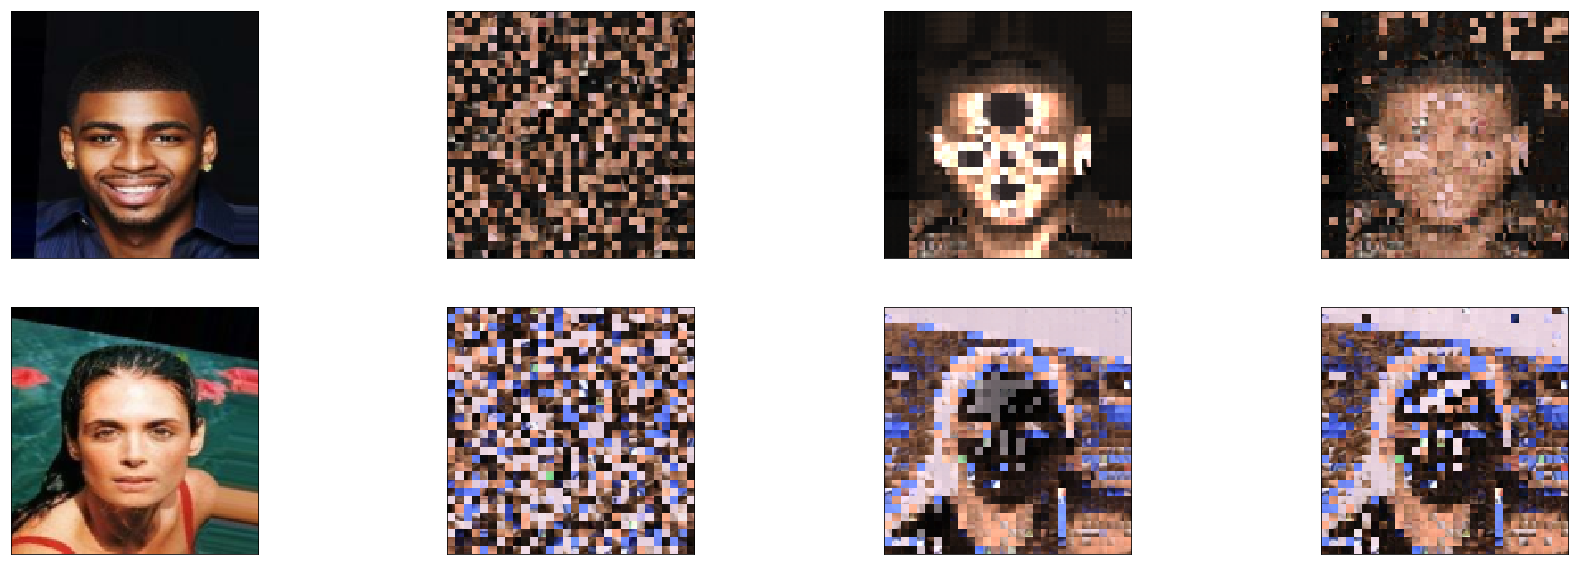

In [7]:
rrr,ma=plot_results(0,'other')


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(2, 900, 5, 5, 3)
[0, 0]
[0, 1]


W0425 17:32:28.754187 140422205343552 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.0
72.6892080307


KeyboardInterrupt: 

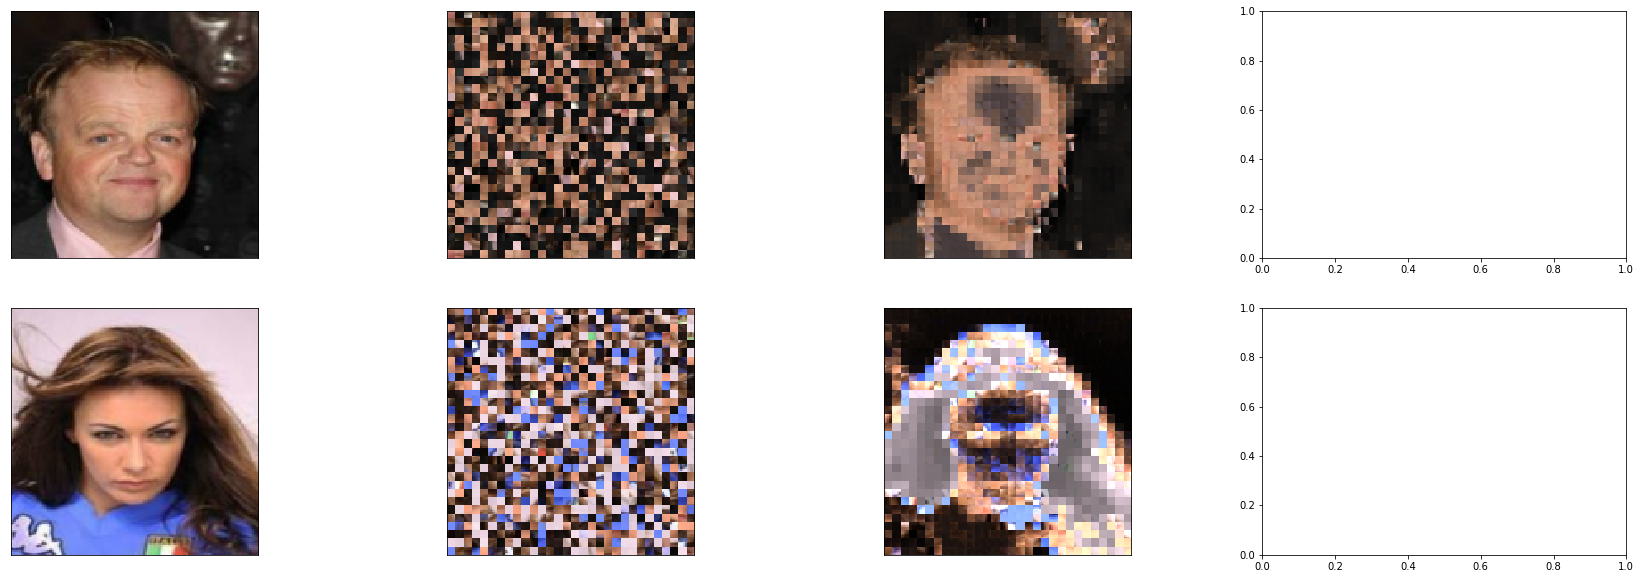

In [8]:
rr,ma2=plot_results(0,'self')


In [10]:
images = []
batch = 10
test_ds = tfds.as_numpy(tfds.load(name='celeb_a',batch_size=batch)['test'])
for _ in range(100):
    
    images.append(next(test_ds)['image'])

In [13]:
np.save('celeba_images',np.array(images))

In [15]:
aa=np.load('celeba_images.npy')

(100, 10, 218, 178, 3)